In [70]:
# Load libraries

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Activation, Flatten, Dropout
from keras.layers import Cropping2D, Conv2D, MaxPooling2D

## LOAD DATA SET

In [31]:
# Load Data Set from Simulator
samples_sim = []
with open('data_mac/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples_sim.append(line)
print("Done Loading Data")    

# Split the data. 20% for validation 80% training
train_samples, validation_samples = train_test_split(samples_sim,test_size=0.20)

images = []
measurements = []

for sample_data in train_samples:
    source_path = sample_data[0] # Store the center image only [1] is left, [2] is right
    filename = (source_path).split('/')[-1]
    img_path = 'data_mac/IMG/' + filename
    img = cv2.imread(img_path)[:,:,::-1]
    images.append(img)
    measurement = float(sample_data[3]) # Steering angle, predicted variable
    measurements.append(measurement)


Done Loading Data


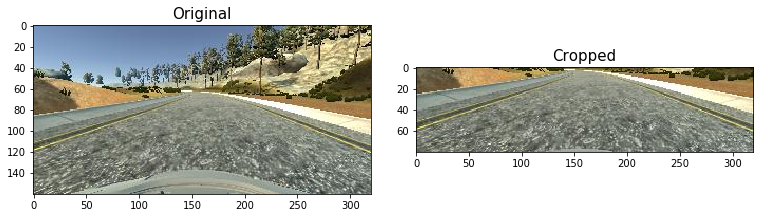

In [62]:
# Visualise one image from dataset

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(images[0])
ax1.set_title('Original', fontsize=15)
ax1.axis('on')

ax2.imshow(images[0][60:][:80], cmap='gray')
ax2.set_title('Cropped', fontsize=15)
ax2.axis('on')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [22]:
X_train = np.array(images)
y_train = np.array(measurements)
print(X_train[0].shape)

# Number of training examples
n_train = len(X_train)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

(160, 320, 3)
Number of training examples = 756
Image data shape = (160, 320, 3)
Number of classes = 23


### Augmenting Image Collection

In [65]:
collection_images = []
collection_measurements = []
for image, measurement in zip(images, measurements):
    collection_images.append(image)
    collection_measurements.append(measurement)
    collection_images.append(cv2.flip(image,1))
    collection_measurements.append(measurement*-1.0)
    
X_train = np.array(collection_images)
y_train = np.array(collection_measurements)
print(X_train[0].shape)

# Number of training examples
n_train = len(X_train)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("NEW Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

(160, 320, 3)
NEW Number of training examples = 1512
Image data shape = (160, 320, 3)
Number of classes = 33


## TRAINING THE MODEL

In [49]:
# TRAINING ...

# Create the Sequential model
model = Sequential()
n_out = 1
#1st Layer - Add a flatten layer
model.add(Flatten(input_shape=(160, 320, 3))) 
print(model.output_shape)
'''Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is 
the element-wise activation function passed as the activation argument, kernel is a weights matrix 
created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).'''
model.add(Dense(n_out))
print(model.output_shape)

model.compile(loss='mse', optimizer='adam')
model.fit(X_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=10)
model.save('models/model_basic_2.h5')
print('finished training')

(None, 153600)
(None, 1)


/Users/daniel.reyna/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  app.launch_new_instance()


Train on 1209 samples, validate on 303 samples
Epoch 1/10
1209/1209 [==============================] - 1s 882us/step - loss: 52224041.5972 - val_loss: 4739669.8531
Epoch 2/10
1209/1209 [==============================] - 1s 445us/step - loss: 1498102.3778 - val_loss: 169436.7128
Epoch 3/10
1209/1209 [==============================] - 1s 448us/step - loss: 58090.6502 - val_loss: 22500.2572
Epoch 4/10
1209/1209 [==============================] - 1s 441us/step - loss: 13412.2427 - val_loss: 9537.7130
Epoch 5/10
1209/1209 [==============================] - 1s 441us/step - loss: 10195.8822 - val_loss: 7052.1983
Epoch 6/10
1209/1209 [==============================] - 1s 443us/step - loss: 7278.5008 - val_loss: 5683.8785
Epoch 7/10
1209/1209 [==============================] - 1s 455us/step - loss: 6310.5516 - val_loss: 5195.6850
Epoch 8/10
1209/1209 [==============================] - 1s 464us/step - loss: 4869.3723 - val_loss: 5590.0574
Epoch 9/10
1209/1209 [==============================] - 1

https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
https://keras.io/layers/core/
https://github.com/harveenchadha/Udacity-CarND-Behavioral-Cloning-Final/blob/master/model.py


### Training Model

Normalisation and Zero mean centering

In [74]:
# TRAINING ...
n_out = 1 # Number of classes to predict. This case: steering angle

# Create the Sequential model
model = Sequential()

# Crop images to our ROI. cropping = (y11,y21), (y12,y22)
model.add(Cropping2D(cropping=((70,20), (0,0)), input_shape=image_shape))

# Pre-process the Data Set. Normalisation and Zero mean centering. 
# The -.5 will shift the mean (0.5) to zero!
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=image_shape))

#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 8, kernel_size = 5, strides = 1, 
                 activation = 'relu'))
#Pooling layer 1
model.add(MaxPooling2D(pool_size = 2, strides = 2))

#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, kernel_size = 5,strides = 1,
                 activation = 'relu'))
#Pooling Layer 2
model.add(MaxPooling2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())

#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))

#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))

#Layer 5
#Output Layer
model.add(Dense(units = n_out))

#Compile and Fit
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=5)
model.save('models/model_LeNet.h5')

print('finished training')

/Users/daniel.reyna/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1209 samples, validate on 303 samples
Epoch 1/5
1209/1209 [==============================] - 20s 16ms/step - loss: 0.2110 - acc: 0.7270 - val_loss: 0.0225 - val_acc: 0.7558
Epoch 2/5
1209/1209 [==============================] - 19s 16ms/step - loss: 0.0215 - acc: 0.7469 - val_loss: 0.0193 - val_acc: 0.7558
Epoch 3/5
1209/1209 [==============================] - 19s 16ms/step - loss: 0.0191 - acc: 0.7469 - val_loss: 0.0160 - val_acc: 0.7558
Epoch 4/5
1209/1209 [==============================] - 19s 16ms/step - loss: 0.0161 - acc: 0.7469 - val_loss: 0.0154 - val_acc: 0.7591
Epoch 5/5
1209/1209 [==============================] - 19s 16ms/step - loss: 0.0146 - acc: 0.7486 - val_loss: 0.0132 - val_acc: 0.7591
finished training


LOG

Using normal regression
- 529 Images. Loss from 12.7503 to 0.1161. Acc 0.4518, NO cropping images
- 1512 Images. Flip and generate new ones, Loss BAD. Classes from 23 to 33!
- 1512 Images. Loss went down, Acc up to 0.4210

Using LeNet
- 1512 Images. 